In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as pltclr
import matplotlib.patches as patch
import time
import skimage

import os

from utils.UNeXt import UNet
from utils.data_processing import CellDataset, SubsetSampler

from utils.nb_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline
import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
modelinfo = torch.load('model.pt', map_location=torch.device('cuda:0'))
model = UNet(**modelinfo['model_kwargs'], model_idx=0)
model.load_state_dict(modelinfo['model'])

LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'exp_schedule': {'type': 'linear', 'width': 311.0, 'e_crit': 30.0}, 'strainenergy_regularization': 0.1, 'reg_schedule': {'type': 'linear', 'width': 311.0, 'e_crit': 30.0}, 'loss_kwargs': {'max_force': 8.0}}


<All keys matched successfully>

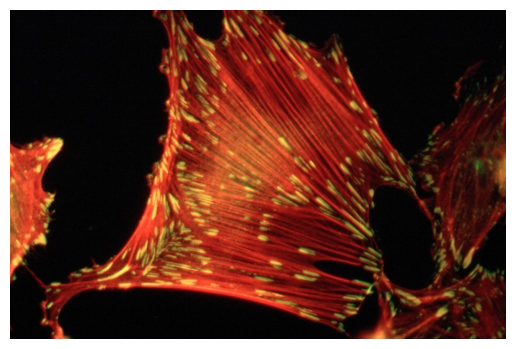

In [57]:
from PIL import Image

# Load the image
image_path = "data-from-open-sources/vinculin-rat-embryo.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

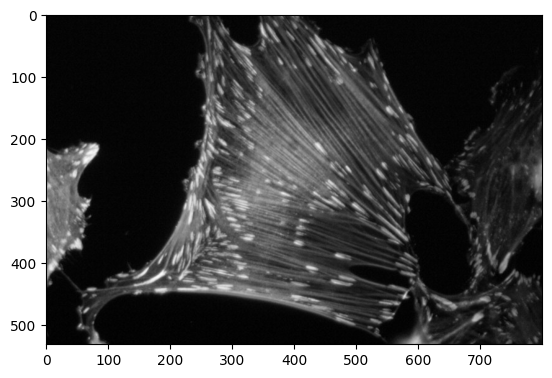

In [58]:
image = Image.open(image_path).convert('L')
plt.imshow(image, cmap='gray')

In [59]:
image = image.resize((256,256))
image_array = np.array(image)
image_array = image_array/255.0

In [60]:
input_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0).to(torch.device('cuda:0'))

In [61]:
height, width = input_tensor.shape[2], input_tensor.shape[3]
tensor_with_8_channels = torch.zeros(1, 8, height, width).to(torch.device('cuda:0'))
tensor_with_8_channels[:, 0, :, :] = input_tensor

for i in range(1,8):
    tensor_with_8_channels[:, i, :, :] = tensor_with_8_channels[:, 0, :, :]




In [72]:
model.eval()
model.to(torch.device('cuda:0'))
input_tensor = input_tensor.float() # bias in the model are in float
with torch.no_grad():
    output = model(input_tensor)

output.shape


torch.Size([1, 2, 256, 256])

input had 8 channels while output has 2, which I think is expected because the channels correspond to the x and y coordinate force mask

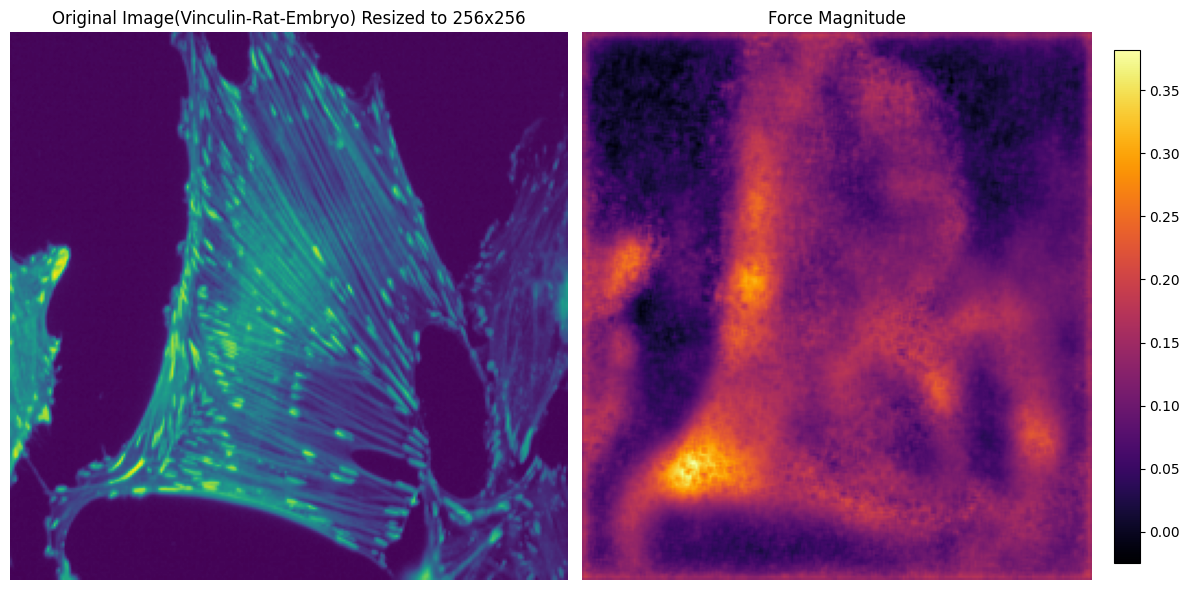

In [73]:
output = output.cpu().numpy().squeeze()
force_mag = output[0]
force_ang = output[1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Displaying the original image
axs[0].imshow(image, aspect='auto')
axs[0].set_title('Original Image(Vinculin-Rat-Embryo) Resized to 256x256')
axs[0].axis('off')

# Displaying the force magnitude
cax = axs[1].imshow(force_mag, cmap='inferno', aspect='auto')
axs[1].set_title('Force Magnitude')
axs[1].axis('off')

# Adding a colorbar for the second subplot
fig.colorbar(cax, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


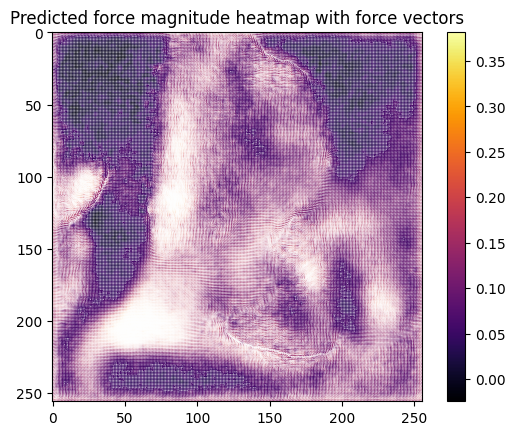

In [74]:
fx = force_mag*np.cos(force_ang)
fy = force_mag*np.sin(force_ang)

quiver_plot_height, quiver_plot_width = fx.shape
X,Y = np.meshgrid(np.arange(quiver_plot_width), np.arange(quiver_plot_height))

plt.imshow(force_mag, cmap='inferno')
plt.colorbar()
plt.title('Predicted force magnitude heatmap with force vectors')
plt.quiver(X, Y, fx, fy, color='w', scale=20, width=0.003, alpha=0.8)
plt.show()